In [113]:
pip install gurobipy haversine

Note: you may need to restart the kernel to use updated packages.


In [9]:
import numpy as np
from gurobipy import *
from scipy.spatial import distance_matrix
from scipy.spatial import ConvexHull
from numpy import random
from haversine import haversine
import time
import pandas as pd

# 한글폰트 깨짐 오류 해결용
import matplotlib as mpl
mpl.rcParams['axes.unicode_minus'] = False
from matplotlib import pyplot as plt
plt.rcParams['font.family'] = 'NanumGothic'

# 1. 접근성 데이터 좌표 변환

In [12]:
#selected_candidates = ['오류2동', '도봉2동', '개봉1동', '구로2동', '상도1동', '양재1동', '신정4동', '공덕동', '성산2동', '세곡동', '북가좌2동', '오금동', '암사1동', '천호2동', '상계1동', '월계3동', '종암동', '도봉1동', '장안1동', '신내1동']
selected_candidates = ['도봉2동', '구로2동', '상도1동', '양재1동', '신정4동', '공덕동', '성산2동', '세곡동', '오금동', '암사1동', '천호2동', '상계1동', '월계3동', '종암동', '도봉1동', '신내1동']


# 좌표 csv데이터 초기화
empty_df = pd.DataFrame()
empty_df.to_csv('fixed_point_data.csv')
empty_df.to_csv('map_points_data.csv')
empty_df.to_csv('opts_sites_data.csv')

In [13]:
def generate_points(candidate_dong):
    입지후보지 = pd.read_csv('./data/data_revised.csv', encoding='cp949')
    입지후보지 = 입지후보지[입지후보지['행정동명'] == candidate_dong]

    bus1 = pd.read_csv('./data/서울시_버스정류장_행정동추가.csv', encoding='cp949')
    bus1 = bus1[bus1['행정동'] == candidate_dong]

    subway1 = pd.read_csv('./data/서울시_지하철역_행정동추가.csv', encoding='cp949')

    subway1 = subway1[subway1['행정동'] == candidate_dong]

    bus_points = np.array([list(i) for i in zip(bus1['Y좌표'], bus1['X좌표'])])

    sub_points = np.array([list(i) for i in zip(subway1['위도'], subway1['경도'])])

    fixed_point = list(bus_points) + list(sub_points)
    fixed_point = np.array(fixed_point)
    # fixed_point = pd.DataFrame({'위도': fixed_point[:, 0], '경도': fixed_point[:, 1]})
    station_points = np.array(fixed_point)
    #print(fixed_point)
    
    center_candidate = np.concatenate((np.array(입지후보지["위도"]), np.array(입지후보지["경도"])), axis=0)

    fixed_point_df = pd.DataFrame(fixed_point, columns=["위도", "경도"])

    
    # 새 fixed_point 데이터를 csv에 추가하기 (동이름 컬럼 붙혀서)
    fixed_point_df['행정동'] = candidate_dong
    
    df = pd.read_csv('fixed_point_data.csv', encoding='cp949')
    df = pd.concat([df, fixed_point_df])
    df.to_csv('fixed_point_data.csv', encoding='cp949')
    
    
    return fixed_point, center_candidate, station_points



# 2. 중심좌표와 가장 먼 정류장 좌표사이 길이 구하기


In [14]:
def map_point(center_point, station_points):
    max_radious = -1
    for station_point in station_points:
        distance = (center_point[0] - station_point[0]) ** 2 + (center_point[0] - station_point[0]) ** 2
        max_radious = max(max_radious,np.sqrt(distance))
    left_upper_point = [center_point[0] - max_radious, center_point[1] + max_radious]
    right_lower_point = [center_point[0] + max_radious, center_point[1] - max_radious]
    x_size, y_size = 15, 15
    mapPoints = []
    for y in range(y_size):
        for x in range(x_size):
            temp = [left_upper_point[0] + ((2 * max_radious) / x_size) * x, left_upper_point[1] - ((2 * max_radious) / y_size) * y]
            mapPoints.append(temp)
    return np.array(mapPoints)

# center_candidate = np.concatenate((np.array(입지후보지["위도"]), np.array(입지후보지["경도"])), axis=0)



# 2. MCLP 확인

In [15]:
def mclp(points,K,radius):
    """
    Solve maximum covering location problem
    Input:
        points: 수요지점 좌표 (기타 인근에 있으면 좋은 시설 좌표)
        K: 배치할 노인놀이터의 수
        radius: 반경 (노인들이 이동하기 적합한 거리)
    Return:
        opt_sites: locations K optimal sites, Numpy array in shape of [K,2]
        f: the optimal value of the objective function
    """
    print('  Number of points %g' % points.shape[0])
    print('  K %g' % K)
    print('  Radius %g' % radius)

    start = time.time()
#     sites = np.array([list(i) for i in zip(prefered_df['위도'], prefered_df['경도'])])
    sites = np.array([list(i) for i in zip(map_points['위도'], map_points['경도'])])
#     sites = np.array([list(i) for i in fixed_point])
    J = sites.shape[0]                                         # 입지후보지 수
    I = points.shape[0]                                        # 수요지점 수
    D = distance_matrix(points,sites)                          # 입지후보지와 수요지점 간 거리 계산
    mask1 = D<=radius
    D[mask1]=1                                                 # 수요지점별로 입지후보지의 반경 내 속하면 1, 아니면 0
    D[~mask1]=0
    # Build model
    m = Model()
    # Add variables
    x = {}
    y = {}
    for i in range(I):                                        
        y[i] = m.addVar(vtype=GRB.BINARY, name="y%d" % i)     # 모델에 수요지점 변수 추가 (변수 유형은 BINARY. 위치별 인수, 변수 이름 y+숫자)
    for j in range(J):
        x[j] = m.addVar(vtype=GRB.BINARY, name="x%d" % j)     # 입지후보지 변수 추가

    m.update()
    # Add constraints
    m.addConstr(quicksum(x[j] for j in range(J)) == K)        # 입지후보지 제약 조건 (K개)

    for i in range(I):                                        # 수요지점 제약 조건
        m.addConstr(quicksum(x[j] for j in np.where(D[i]==1)[0]) >= y[i])

    m.setObjective(quicksum(y[i] for i in range(I)),GRB.MAXIMIZE)     # 목적함수 (제약 조건 포함. 모든 수요지점 더하기)
    m.setParam('OutputFlag', 0)
    m.optimize()
    end = time.time()
    print('----- Output -----')
    print('  Running time : %s seconds' % float(end-start))
    print('  Optimal coverage points: %g' % m.objVal)
    
    solution = []
    if m.status == GRB.Status.OPTIMAL:
        for v in m.getVars():
            # print v.varName,v.x
            if v.x==1 and v.varName[0]=="x":
                solution.append(int(v.varName[1:]))
    print(solution)
    points = np.array(points)
    opt_sites = sites[solution]


    return opt_sites,m.objVal


In [16]:
# # opts_sites, mobjVal = mclp(points, 5, 0.0028)
# # map_points = np.array(map_points)
# # map_points
# map_points = map_point(center_candidate, station_points)
# map_points= pd.DataFrame({'위도': map_points[:, 0], '경도': map_points[:, 1]})

# radious = 0.0028

# # opts_sites, mobjVal = mclp(map_points, 3, radious)
# opts_sites, mobjVal = mclp(fixed_point, 4, radious)
# opts_sites = pd.DataFrame(opts_sites, columns=["경도", "위도"])
# #print(opts_sites)
# #print(map_points)
# #print(fixed_point)
      
# map_points.to_csv('map_points_data.csv')
# opts_sites.to_csv('opts_sites_data.csv')

In [17]:
def plot_result(points,opt_sites,radius, dong):
    '''
    Plot the result
    Input:
        points: input points, Numpy array in shape of [N,2]
        opt_sites: locations K optimal sites, Numpy array in shape of [K,2]
        radius: the radius of circle
    '''
    from matplotlib import pyplot as plt

    fig = plt.figure(figsize=(8,8))
    plt.title(dong)    # 동 이름 제목에 표시

    if isinstance(points, pd.DataFrame):
        points = points.values
    if isinstance(opt_sites, pd.DataFrame):
        opt_sites = opt_sites.values

    plt.scatter(points[:,0],points[:,1],c='C0')
    ax = plt.gca()
    plt.scatter(opt_sites[:,0],opt_sites[:,1],c='C1',marker='+')
    for site in opt_sites:
        circle = plt.Circle(site, radius, color='C1',fill=False,lw=2)
        ax.add_artist(circle)
    ax.axis('equal')
    ax.tick_params(axis='both',left=False, top=False, right=False,
                       bottom=False, labelleft=False, labeltop=False,
                       labelright=False, labelbottom=False)

    # 동별 plot을 이미지로 저장
    plt.savefig('./image/'+str(dong)+'_plot.png')


도봉2동
  Number of points 42
  K 4
  Radius 0.0028
----- Output -----
  Running time : 0.022445201873779297 seconds
  Optimal coverage points: 32
[115, 117, 129, 131]

구로2동
  Number of points 39
  K 4
  Radius 0.0028
----- Output -----
  Running time : 0.004406929016113281 seconds
  Optimal coverage points: 30
[112, 155, 174, 207]

상도1동
  Number of points 46
  K 4
  Radius 0.0028
----- Output -----
  Running time : 0.002174854278564453 seconds
  Optimal coverage points: 36
[33, 64, 66, 80]

양재1동
  Number of points 73
  K 4
  Radius 0.0028
----- Output -----
  Running time : 0.0031807422637939453 seconds
  Optimal coverage points: 39
[55, 72, 112, 168]

신정4동
  Number of points 17
  K 4
  Radius 0.0028
----- Output -----
  Running time : 0.006030082702636719 seconds
  Optimal coverage points: 17
[55, 67, 155, 218]

공덕동
  Number of points 37
  K 4
  Radius 0.0028
----- Output -----
  Running time : 0.00269317626953125 seconds
  Optimal coverage points: 31
[72, 97, 115, 141]

성산2동
  Number 

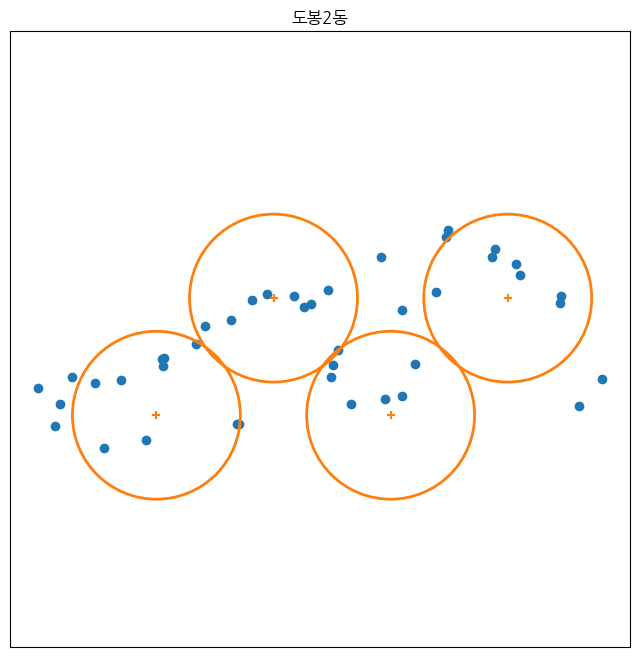

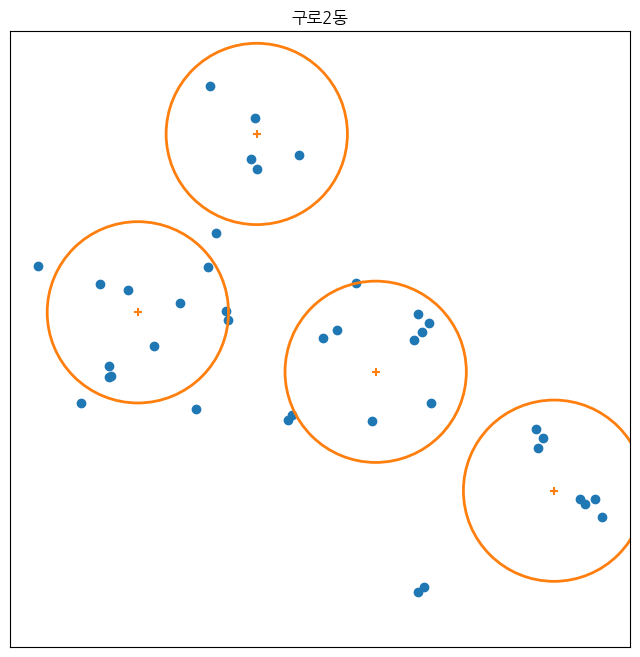

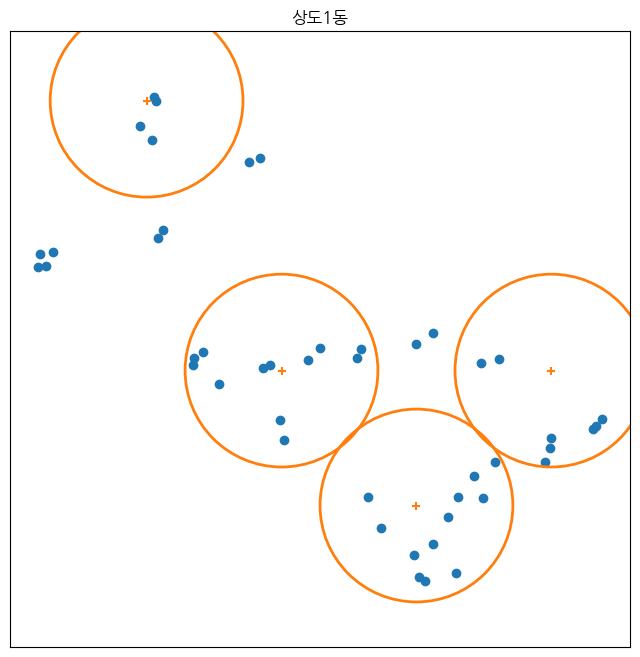

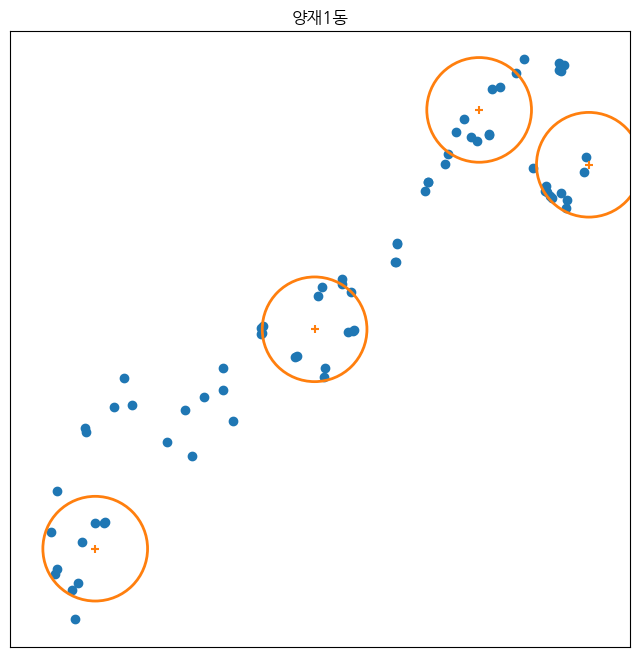

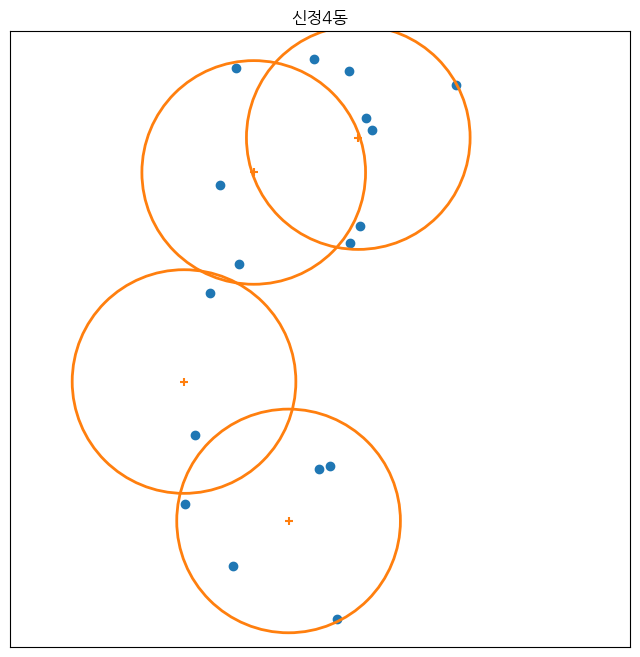

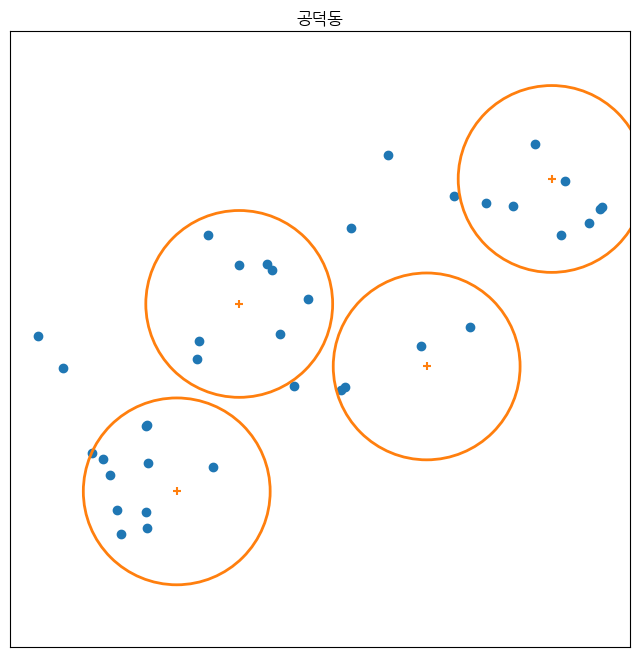

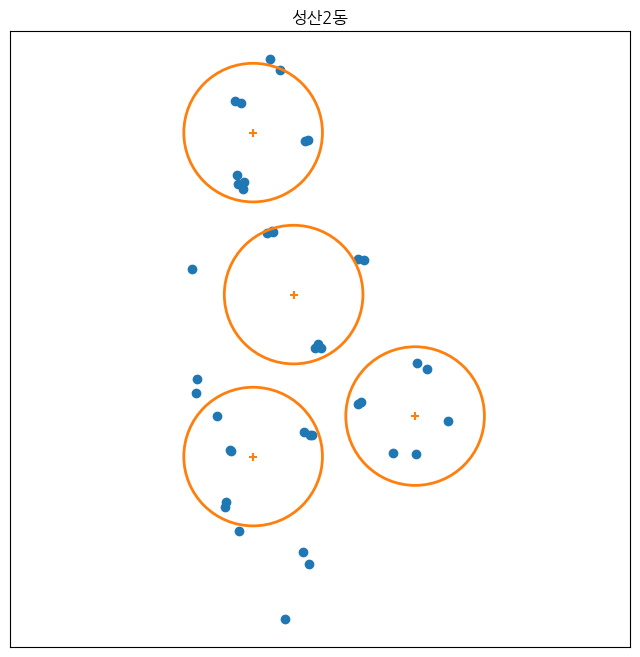

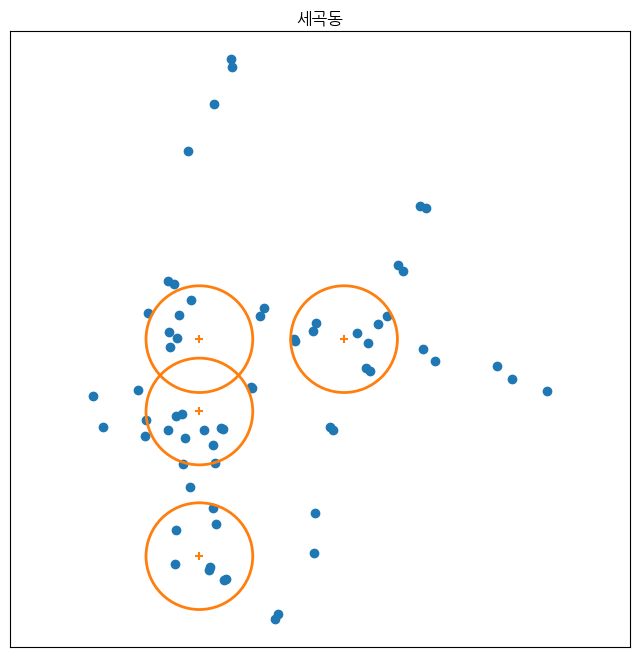

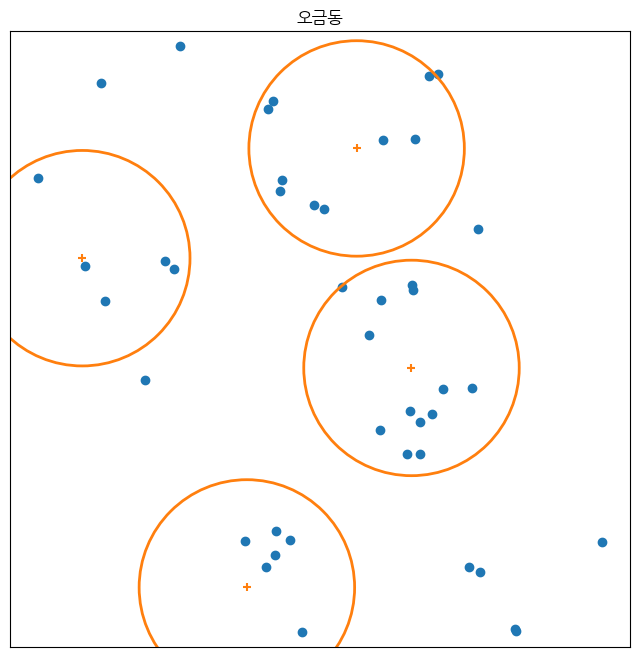

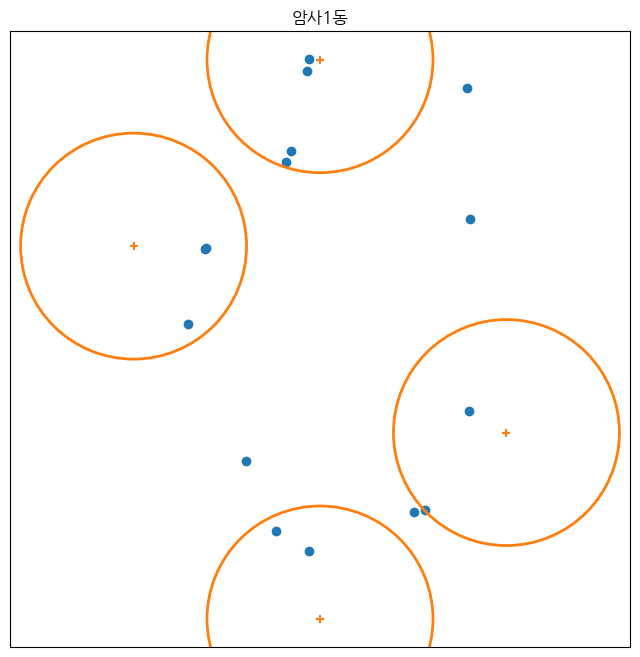

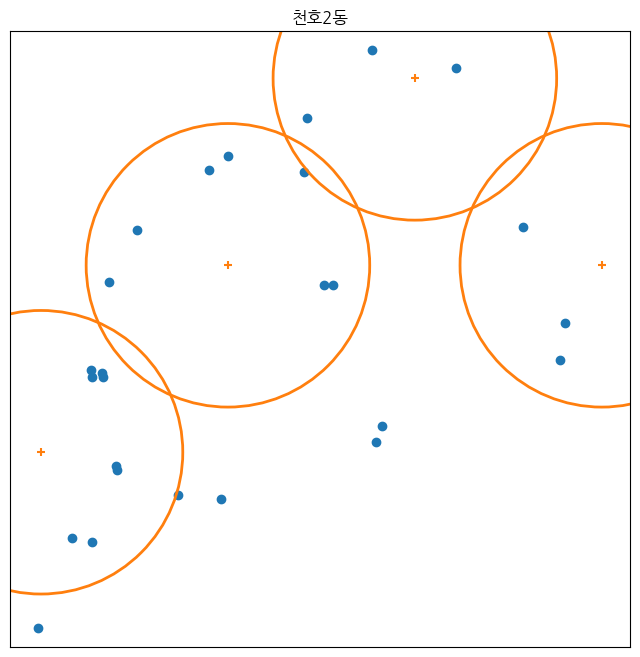

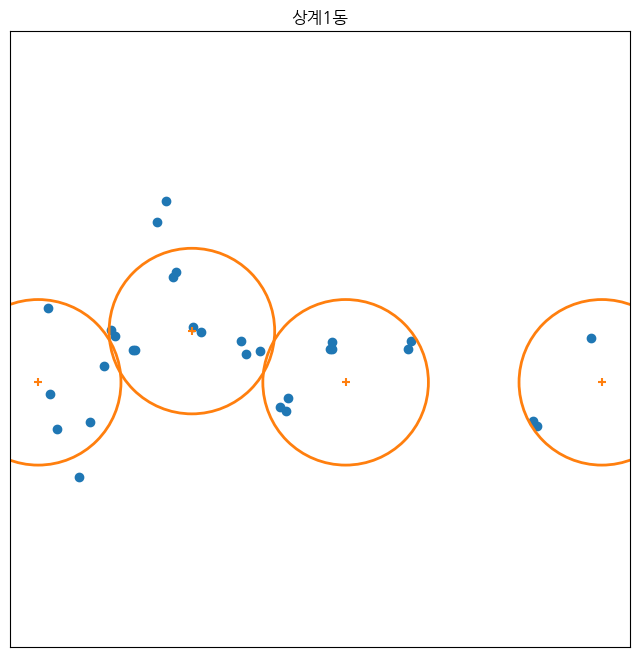

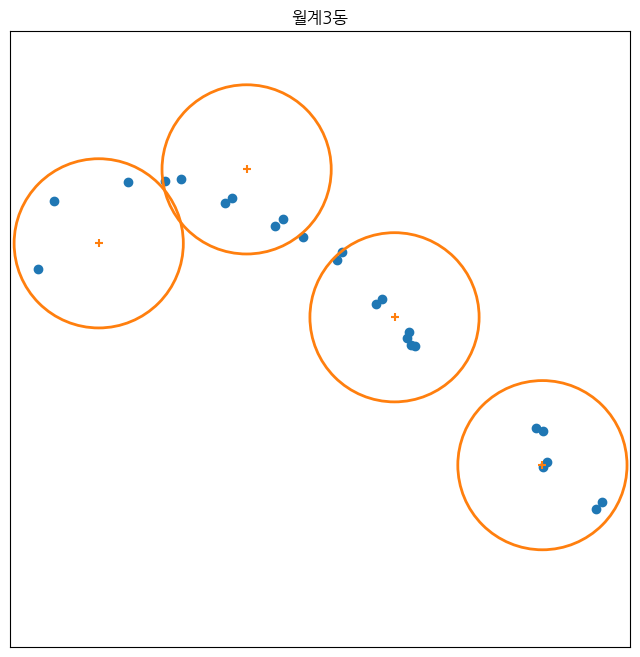

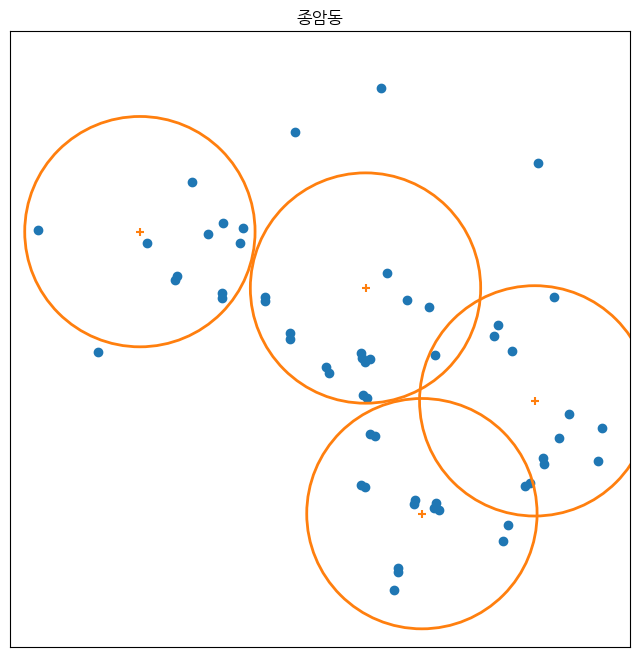

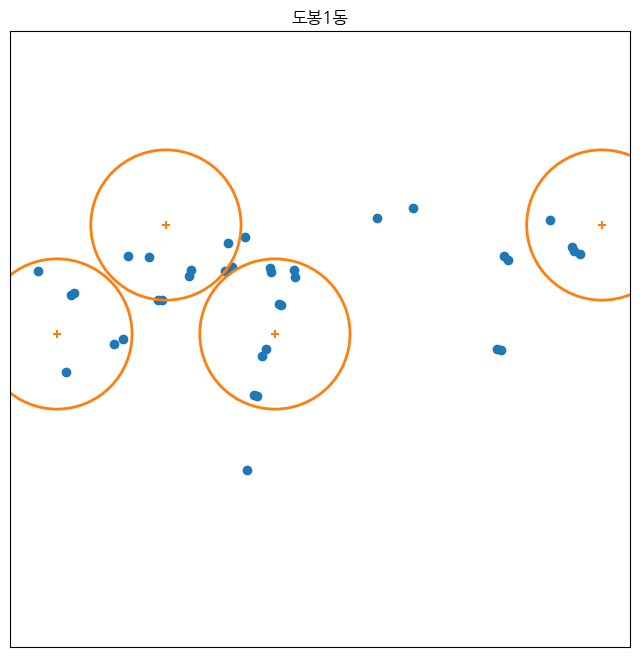

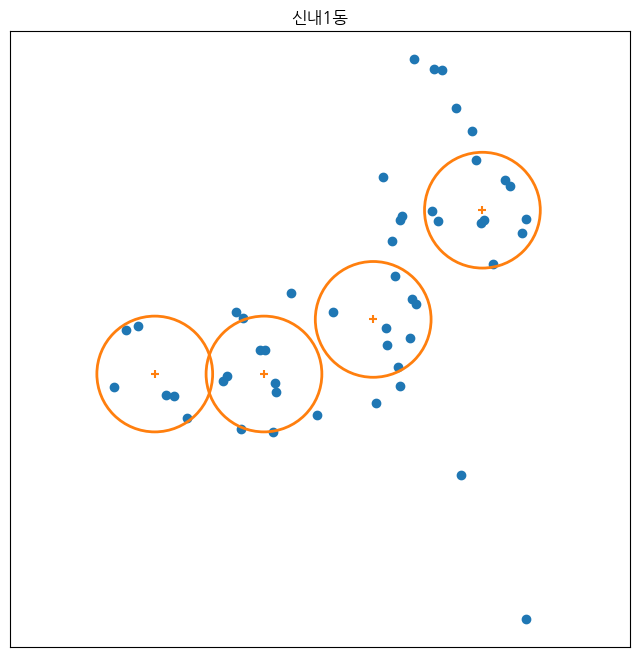

In [18]:
for i in selected_candidates:
    fixed_point, center_candidate, station_points = generate_points(i)
    
    print()
    print(i)
    
    map_points = map_point(center_candidate, station_points)
    map_points = pd.DataFrame({'위도': map_points[:, 0], '경도': map_points[:, 1]})

    radious = 0.0028
    
    opts_sites, mobjVal = mclp(fixed_point, 4, radious)
    opts_sites = pd.DataFrame(opts_sites, columns=["경도", "위도"])
    
    
    # 새 map_points 데이터를 csv에 추가하기 (동이름 컬럼 붙혀서)
    map_points['행정동'] = i
    
    df2 = pd.read_csv('map_points_data.csv', encoding='cp949')
    df2 = pd.concat([df2, map_points])
    df2.to_csv('map_points_data.csv', encoding='cp949')
    
    
    # 새 opts_sites 데이터를 csv에 추가하기 (동이름 컬럼 붙혀서)
    opts_sites['행정동'] = i
    
    df3 = pd.read_csv('opts_sites_data.csv', encoding='cp949')
    df3 = pd.concat([df3, opts_sites])
    df3.to_csv('opts_sites_data.csv', encoding='cp949')
    
    
    # plot 그리기
    plot_result(fixed_point, opts_sites, radious, i)

    

In [9]:
# # plot_result(points, opts_sites, 0.0028)
# plot_result(fixed_point, opts_sites, radious)
